# 04 Effect of radius and number of clusters

In [ ]:
In our previous [tutorial](./02_Quick_start_simulation_data.ipynb), we applied GNN for learning spatial neighbourhood structures in a simulated spatial transcripts data. We used radius graph with radius set as 3 microns. The `radius_r` used for building the spatial RNA-graph is essential and controls the level of spatial aggregation. In this notebook, we explore the effect of large or small radius values in combination with the clustering resolution.

We will examine the results with varying radius values, including [0.5, 1, 3, 5, 15]. 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 
import itertools
import os
from sklearn.cluster import KMeans

In [8]:
data_dir = "/mnt/beegfs/mccarthy/general/backed_up/rlyu/Projects/spatialrna_ms_revision2025/"
k_list = [10,6,5,3,2]

In [9]:
ground_truth_rgb =  pd.read_csv(data_dir+"data/simulated/model.rgb.tsv",sep="\t")
#set(ground_truth_label.cell_label)
c_array = np.array(ground_truth_rgb[["R","G","B"]])
color_m = dict(zip(ground_truth_rgb.cell_label,range(0,10)))

ground_truth_label = pd.read_csv(data_dir+"data/simulated/pixel_label.uniq.tsv.gz",sep="\t")
ground_truth_label
ground_truth_label["ori_id"] = [x for x in range(ground_truth_label.shape[0])]

In [10]:
input_tx = pd.read_csv(data_dir+"data/simulated/matrix.tsv.gz",sep="\t")
ground_truth_label["gene"] = input_tx["gene"]
# ground_truth_label["Count"] = 1

ground_truth_label

X       Y  cell_id    cell_label  cell_shape  ori_id     gene
0         0.0   31.39       98    fibroblast         rod       0      Bgn
1         0.0  345.69      758    fibroblast         rod       1      Cfh
2         0.0  278.56      626    fibroblast         rod       2     Dkk3
3         0.0  317.52      692    fibroblast     diamond       3    Sparc
4         0.0  372.04      792    fibroblast     diamond       4     Rcn3
...       ...     ...      ...           ...         ...     ...      ...
557516  500.0  458.91      957  Kupffer_cell         rod  557516     Lyz2
557517  500.0  389.13      857  keratinocyte      circle  557517     Gm94
557518  500.0  169.83      395  keratinocyte         rod  557518    Krt6a
557519  500.0   37.70       99  keratinocyte  background  557519  S100a16
557520  500.0   86.95      198  keratinocyte      circle  557520    Krt6a

[557521 rows x 7 columns]

## The clustering labels by different radius and k

We load the clustering results that were obtained from different input radius for graph construction and different number of clusters.

In [11]:
kmeans_labels_df = pd.read_csv("../data/radius_and_k.csv",index_col=0)
kmeans_labels_df

r0.5_k10  r0.5_k6  r0.5_k5  r0.5_k3  r0.5_k2  r1_k10  r1_k6  r1_k5  \
0              7        5        2        2        1       3      2      2   
1              7        5        2        2        1       3      2      2   
2              7        5        2        2        1       3      2      2   
3              7        5        2        2        1       3      2      2   
4              7        5        2        2        1       3      2      2   
...          ...      ...      ...      ...      ...     ...    ...    ...   
557516         8        5        1        1        0       7      4      4   
557517         2        2        2        2        1       5      3      3   
557518         4        5        2        2        1       5      3      3   
557519         4        5        2        2        1       5      3      3   
557520         2        2        2        2        1       5      3      3   

        r1_k3  r1_k2  ...  r5_k10  r5_k6  r5_k5  r5_k3  r5_k2  r15_k10  \
0           2      1  ...       3      5      1      1      1        3   
1           2      1  ...       3      5      1      1      1        3   
2           2      1  ...       3      5      1      1      1        4   
3           2      1  ...       3      5      1      1      1        3   
4           2      1  ...       3      5      1      1      1        3   
...       ...    ...  ...     ...    ...    ...    ...    ...      ...   
557516      1      1  ...       9      2      2      2      1        5   
557517      2      1  ...       2      3      3      2      0        5   
557518      2      1  ...       2      3      3      2      0        5   
557519      2      1  ...       2      3      3      2      0        5   
557520      2      1  ...       2      3      3      2      0        5   

        r15_k6  r15_k5  r15_k3  r15_k2  
0            3       3       2       1  
1            3       3       2       1  
2            5       2       2       1  
3            3       3       2       1  
4            3       3       2       1  
...        ...     ...     ...     ...  
557516       4       4       1       1  
557517       4       4       1       1  
557518       4       4       1       1  
557519       4       4       1       1  
557520       4       4       1       1  

[557521 rows x 25 columns]

In [12]:
## define helper function for matching Kmeans labels with groundtruth labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

def find_cell_label_prop_in_k(kmeans_labels, ground_truth_label):
    contingency_table = pd.crosstab(ground_truth_label.cell_label, [str(x) for x in kmeans_labels])
    long_format = contingency_table.stack().reset_index()
    long_format.columns = ['cell_label', 'kmean_label', 'Count']
    long_format['Proportion'] = long_format.groupby('cell_label')['Count'].transform(lambda x: x / x.sum())
    return long_format


'''
match the derived kmeans labels to cell type labels, simply by confusion matrix
'''
def assign_cell_label(kmeans_labels, ground_truth_label):
    contingency_table = pd.crosstab(ground_truth_label.cell_label, [str(x) for x in kmeans_labels])
    long_format = contingency_table.stack().reset_index()
    long_format.columns = ['cell_label', 'kmean_label', 'Count']
    long_format['Proportion'] = long_format.groupby('cell_label')['Count'].transform(lambda x: x / x.sum())
    match_pair = long_format.iloc[long_format.groupby('cell_label')['Proportion'].idxmax()]
    
    match_pair_dict = dict(zip(match_pair.kmean_label,match_pair.cell_label))
    return match_pair,match_pair_dict

def calculate_ari(kmeans_labels, ground_truth_label):
    res = adjusted_rand_score(kmeans_labels,ground_truth_label.cell_label)
    return res
 

In [13]:
matched_pairs = {}
for col_n in kmeans_labels_df.columns:
    matched_pairs[col_n] = assign_cell_label(kmeans_labels_df[col_n],ground_truth_label)

In [14]:
confusion_list = {}
for col_n in kmeans_labels_df.columns:
    confusion_list[col_n] = find_cell_label_prop_in_k(kmeans_labels_df[col_n],ground_truth_label)

In [15]:
ari_list = {}
for col_n in kmeans_labels_df.columns:
    ari_list[col_n] = calculate_ari(kmeans_labels_df[col_n],ground_truth_label)

In [16]:
kmeans_labels_df.columns

Index(['r0.5_k10', 'r0.5_k6', 'r0.5_k5', 'r0.5_k3', 'r0.5_k2', 'r1_k10',
       'r1_k6', 'r1_k5', 'r1_k3', 'r1_k2', 'r3_k10', 'r3_k6', 'r3_k5', 'r3_k3',
       'r3_k2', 'r5_k10', 'r5_k6', 'r5_k5', 'r5_k3', 'r5_k2', 'r15_k10',
       'r15_k6', 'r15_k5', 'r15_k3', 'r15_k2'],
      dtype='object')

In [17]:
confusion_list.keys()

dict_keys(['r0.5_k10', 'r0.5_k6', 'r0.5_k5', 'r0.5_k3', 'r0.5_k2', 'r1_k10', 'r1_k6', 'r1_k5', 'r1_k3', 'r1_k2', 'r3_k10', 'r3_k6', 'r3_k5', 'r3_k3', 'r3_k2', 'r5_k10', 'r5_k6', 'r5_k5', 'r5_k3', 'r5_k2', 'r15_k10', 'r15_k6', 'r15_k5', 'r15_k3', 'r15_k2'])

For example, we can have a look at column r15_k10 in confusion_list, it shows for each cell_label, the proportion of each kmeans_label.

In [18]:
confusion_list["r15_k10"]

cell_label kmean_label  Count  Proportion
0   Kupffer_cell           0   3608    0.073655
1   Kupffer_cell           1   4482    0.091497
2   Kupffer_cell           2  15121    0.308686
3   Kupffer_cell           3   6356    0.129754
4   Kupffer_cell           4   7102    0.144983
..           ...         ...    ...         ...
95  keratinocyte           5  63199    0.844624
96  keratinocyte           6   6469    0.086455
97  keratinocyte           7      0    0.000000
98  keratinocyte           8      0    0.000000
99  keratinocyte           9   2026    0.027077

[100 rows x 4 columns]

## Transcripts assigned in Kmeans labels for each radius and K combination across cell types

We next calculate for each radius and K combination, for each cell type, the proportion of transcripts assigned into each cluster.

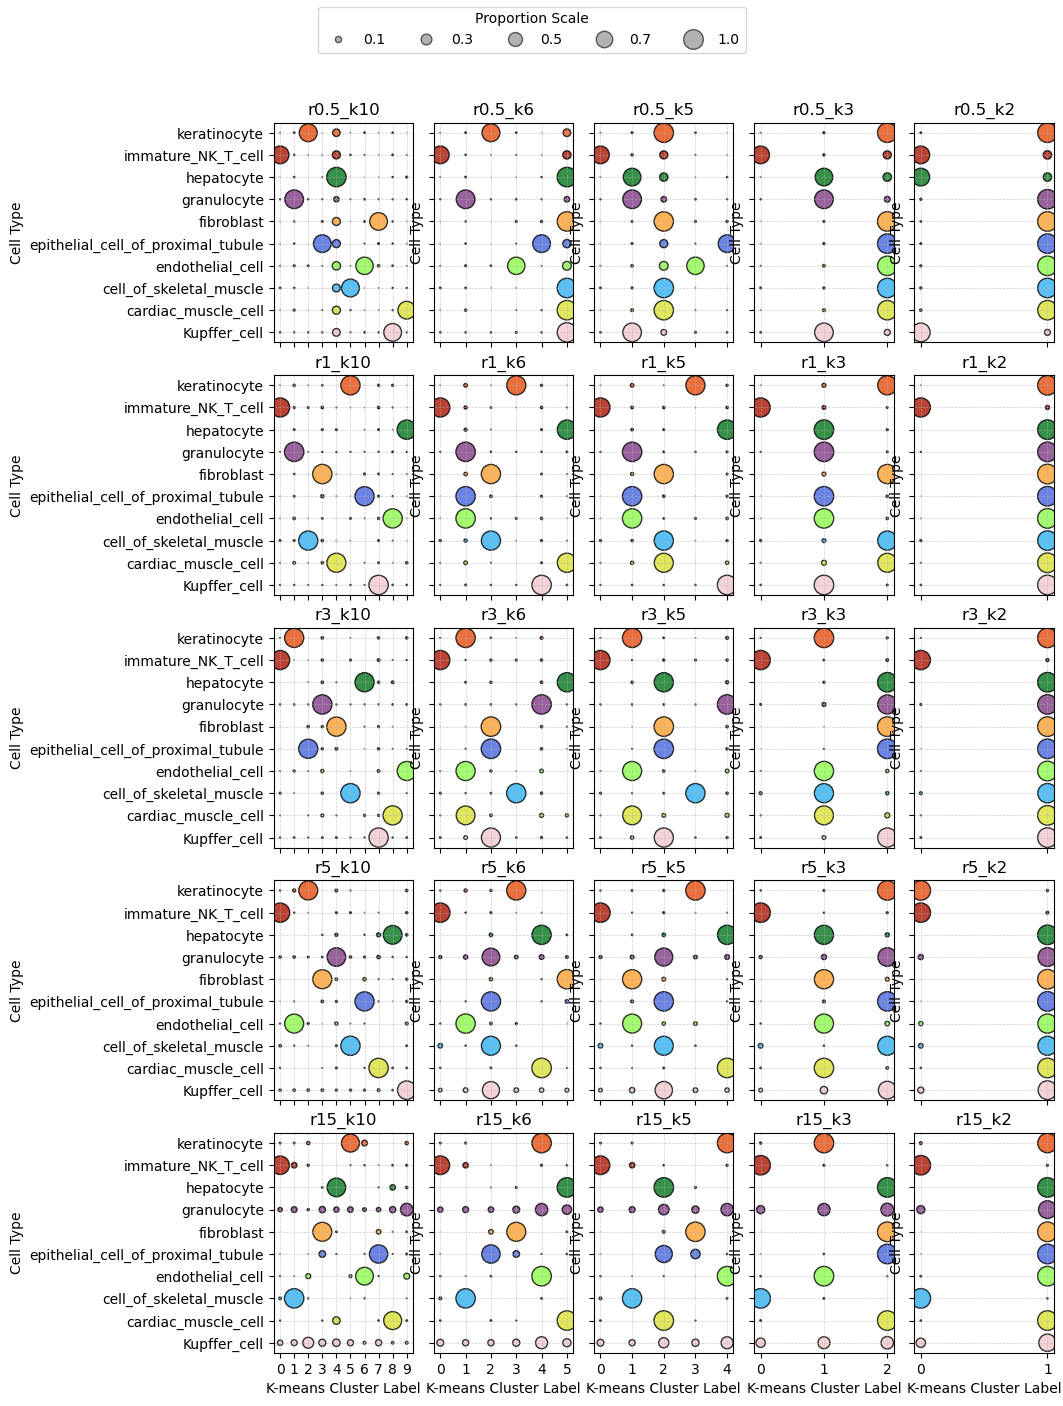

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
# mapping from cell_label to RGB hex colors
def rgb_to_hex(r, g, b):
    return "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255))

# Add hex color to the color_df
ground_truth_rgb['hex'] = ground_truth_rgb.apply(lambda row: rgb_to_hex(row['R'], row['G'], row['B']), axis=1)

# Create a mapping from cell_label to hex color
color_map = dict(zip(ground_truth_rgb['cell_label'], ground_truth_rgb['hex']))
fig, axes = plt.subplots(5, 5, figsize=(12, 15), sharey=True)

for idx, (radii, ax) in enumerate(zip(confusion_list.keys(), axes.flatten())):
    #print(idx)
    df = confusion_list[radii].copy()
    #print(df.shape)
    df['color'] = df['cell_label'].map(color_map)
    ax.scatter(
        x=df['kmean_label'],
        y=df['cell_label'],
        s=df['Proportion'] * 200,
        c=df['color'],
        alpha=0.8,
        edgecolors="k"
    )
    
    ax.set_title(f"{radii}")
    ax.set_xlabel("K-means Cluster Label")
    ax.set_ylabel("Cell Type")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    if idx < 20:  # Rows 0–3 (5x5 grid => last row is idx 20–24)
        ax.set_xticklabels([])
        ax.set_xlabel("")

## set legend
from matplotlib.lines import Line2D

# Example sizes (adjust as needed based on your data's scale)
example_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]
scale_factor = 200  # same as used in scatterplot

# Create legend elements
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f'{s:.1f}',
        markersize=(s * scale_factor)**0.5,  # Size is sqrt of area
        markerfacecolor='gray',
        alpha=0.6,
        markeredgecolor='k'
    ) for s in example_sizes
]

# Add to figure
fig.legend(
    handles=legend_elements,
    title='Proportion Scale',
    loc='upper center',  # or 'upper right', etc.
    ncol=len(example_sizes),
    frameon=True
)
plt.tight_layout(pad=1)
plt.subplots_adjust(
    left=0.25,    # Left side of subplots
    right=0.9,   # Right side
    top=0.92,     # Top margin
    bottom=0.1,  # Bottom margin
    wspace=0.15,  # Width spacing between subplots
    hspace=0.15   # Height spacing between subplots
)
#plt.subplots_adjust(top=0.15)  # Increase bottom margin (try 0.2 if needed)

plt.savefig("../figures/combined_r_k_ct_prop.png", dpi=300)
plt.show()   


## Plot spatially 

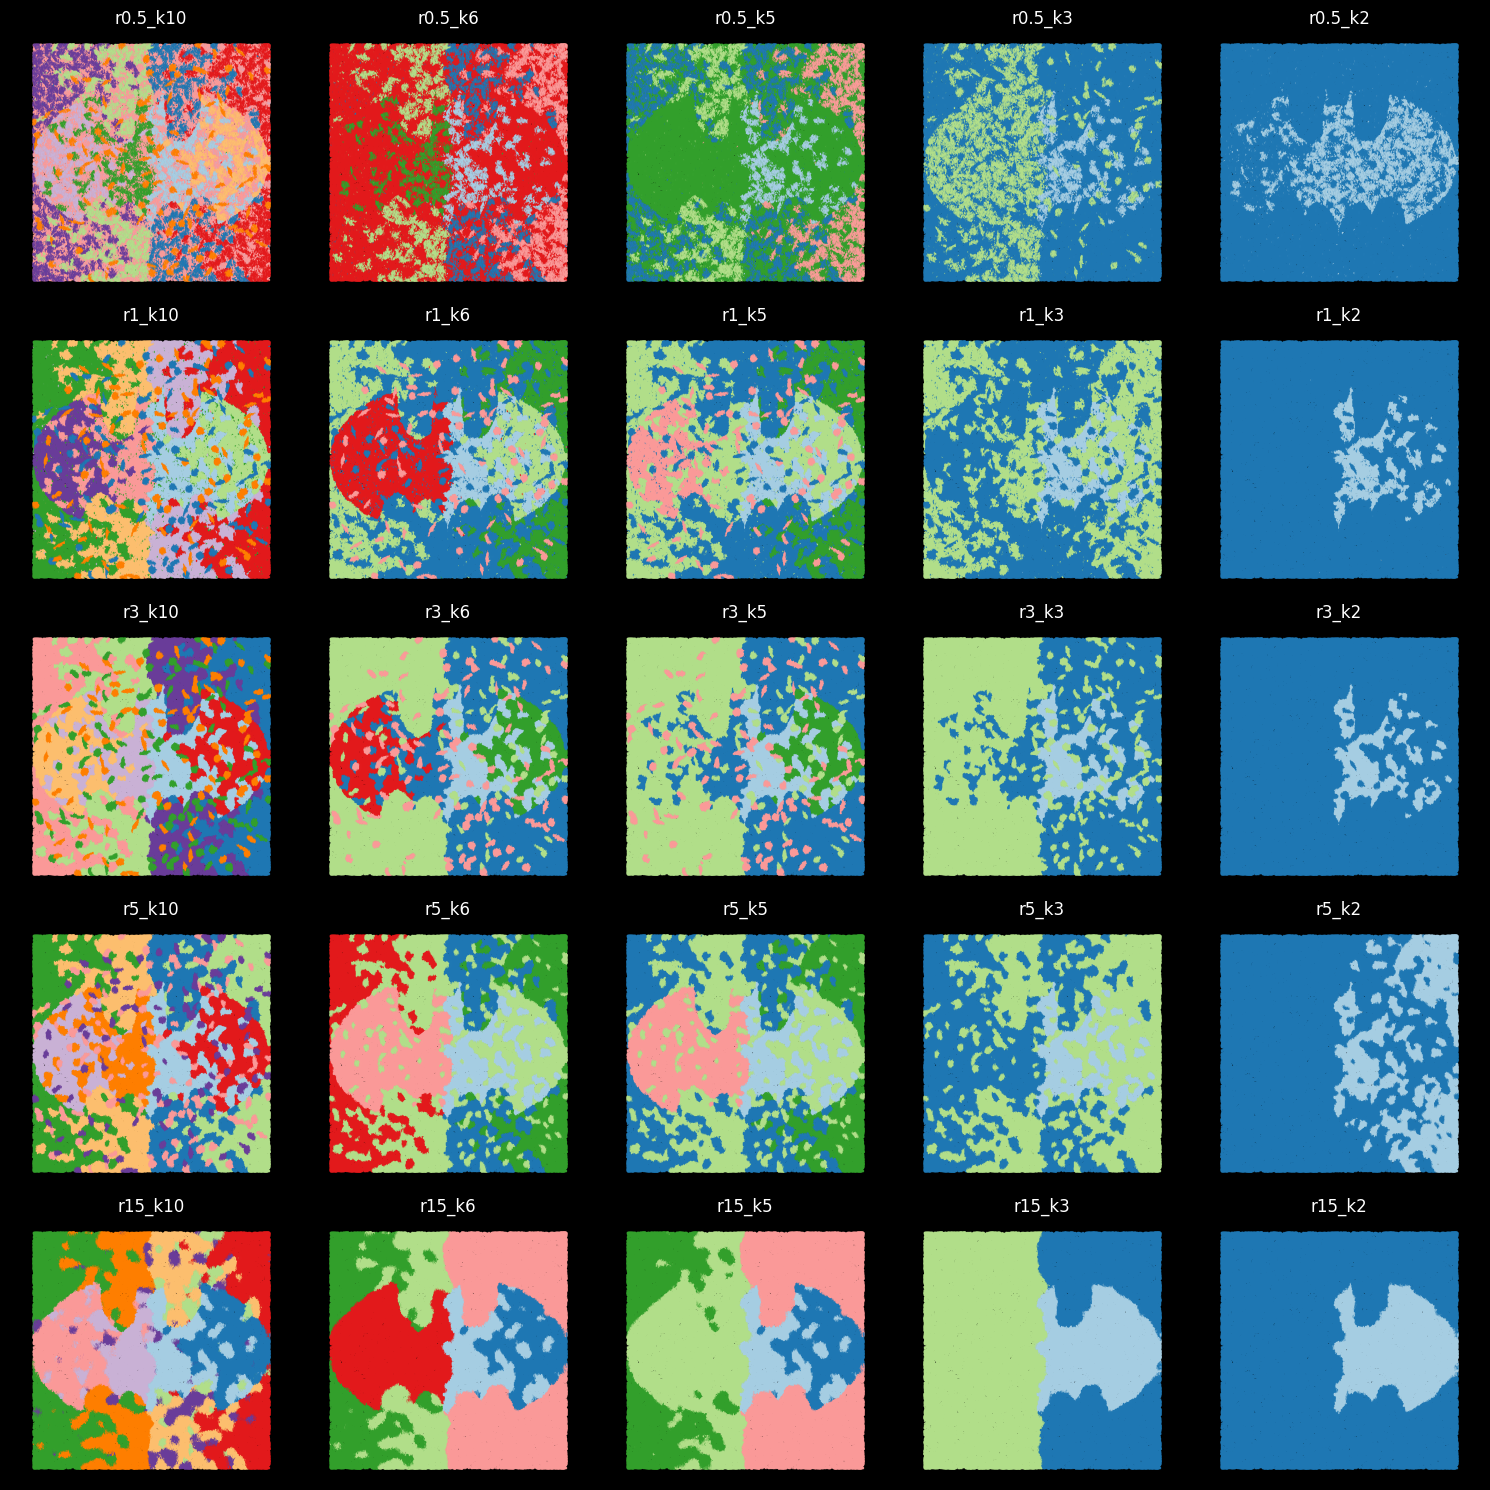

In [128]:
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['figure.dpi'] = '100'
plt.rcParams["scatter.marker"]= ','

plot_res = kmeans_labels_df.columns
palette = sns.color_palette("Paired", n_colors=kmeans_labels_df[plot_res[0]].nunique())

## plots color by the mapped cell label
fig,axes = plt.subplots(5,5,figsize=(15,15),sharey=True)
for col_n, ax in zip(plot_res, axes.flatten()):
    labels = kmeans_labels_df[col_n].values
    unique_labels = np.unique(labels)
    # Create a mapping from cluster label to color
    color_map = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}
    
    # Map colors to each data point
    colors = [color_map[label] for label in labels]
    ax.scatter(
        x=ground_truth_label.X,
        y=ground_truth_label.Y,
        s=0.1,
        c=colors,
        alpha=1,
        marker=","
    )
    ax.set_title(col_n)
    ax.axis("off")
    ax.axis('equal')
plt.tight_layout()
plt.savefig("../figures/radius_and_kv2.png",dpi=300)
plt.show()

## For 10-cluster results, we can match Kmean labels to the 10 ground-truth cell labels

In [20]:
matched_pairs['r0.5_k10']

(                            cell_label kmean_label  Count  Proportion
 8                         Kupffer_cell           8  40191    0.820476
 19                 cardiac_muscle_cell           9  32710    0.812207
 25             cell_of_skeletal_muscle           5  32827    0.824136
 36                    endothelial_cell           6  50875    0.782728
 43  epithelial_cell_of_proximal_tubule           3  55381    0.814055
 57                          fibroblast           7  63849    0.811379
 61                         granulocyte           1  51390    0.905248
 74                          hepatocyte           4  41559    0.982227
 80                  immature_NK_T_cell           0  34814    0.813297
 92                        keratinocyte           2  62443    0.834521,
 {'8': 'Kupffer_cell',
  '9': 'cardiac_muscle_cell',
  '5': 'cell_of_skeletal_muscle',
  '6': 'endothelial_cell',
  '3': 'epithelial_cell_of_proximal_tubule',
  '7': 'fibroblast',
  '1': 'granulocyte',
  '4': 'hepatocy

In [21]:
kmeans_labels_df_labels = kmeans_labels_df[["r0.5_k10","r1_k10","r3_k10","r5_k10"]].copy()
for col_n in kmeans_labels_df_labels.columns:
     kmeans_labels_df_labels[col_n] = kmeans_labels_df_labels[col_n].astype(str).map(matched_pairs[col_n][1]).values

In [25]:
print(ari_list)

{'r0.5_k10': 0.6360496037165597, 'r0.5_k6': 0.29072535393494886, 'r0.5_k5': 0.29282424387856426, 'r0.5_k3': 0.14973820002563204, 'r0.5_k2': 0.09266537890009367, 'r1_k10': 0.9184400845034655, 'r1_k6': 0.5498884407363157, 'r1_k5': 0.48460259049424115, 'r1_k3': 0.23720468043557869, 'r1_k2': 0.03576575573685528, 'r3_k10': 0.9084927306439161, 'r3_k6': 0.48639892319516387, 'r3_k5': 0.3963355191463681, 'r3_k3': 0.24294939510110158, 'r3_k2': 0.037203280286528924, 'r5_k10': 0.8677415695668176, 'r5_k6': 0.5335609853725009, 'r5_k5': 0.4573453033239519, 'r5_k3': 0.2309924739633567, 'r5_k2': 0.10776133994359129, 'r15_k10': 0.623075072848499, 'r15_k6': 0.47500113491479334, 'r15_k5': 0.38899618145745923, 'r15_k3': 0.26424046086530917, 'r15_k2': 0.07907475083168604}


| r\k    | k10 | k6  | k5  | k3  | k2  |
|------|-----|-----|-----|-----|-----|
| r0.5 | 0.64| 0.29| 0.29| 0.15| 0.09|
| r1   | 0.92| 0.55| 0.48| 0.24| 0.04|
| r3   | 0.91| 0.49| 0.40| 0.24| 0.04|
| r5   | 0.87| 0.53| 0.46| 0.23| 0.11|
| r15  | 0.62| 0.48| 0.39| 0.26| 0.08|


In [114]:
kmeans_labels_df_labels

r0.5_k10        r1_k10        r3_k10        r5_k10
0         fibroblast    fibroblast    fibroblast    fibroblast
1         fibroblast    fibroblast    fibroblast    fibroblast
2         fibroblast    fibroblast    fibroblast    fibroblast
3         fibroblast    fibroblast    fibroblast    fibroblast
4         fibroblast    fibroblast    fibroblast    fibroblast
...              ...           ...           ...           ...
557516  Kupffer_cell  Kupffer_cell  Kupffer_cell  Kupffer_cell
557517  keratinocyte  keratinocyte  keratinocyte  keratinocyte
557518  Kupffer_cell  keratinocyte  keratinocyte  keratinocyte
557519  Kupffer_cell  keratinocyte  keratinocyte  keratinocyte
557520  keratinocyte  keratinocyte  keratinocyte  keratinocyte

[557521 rows x 4 columns]

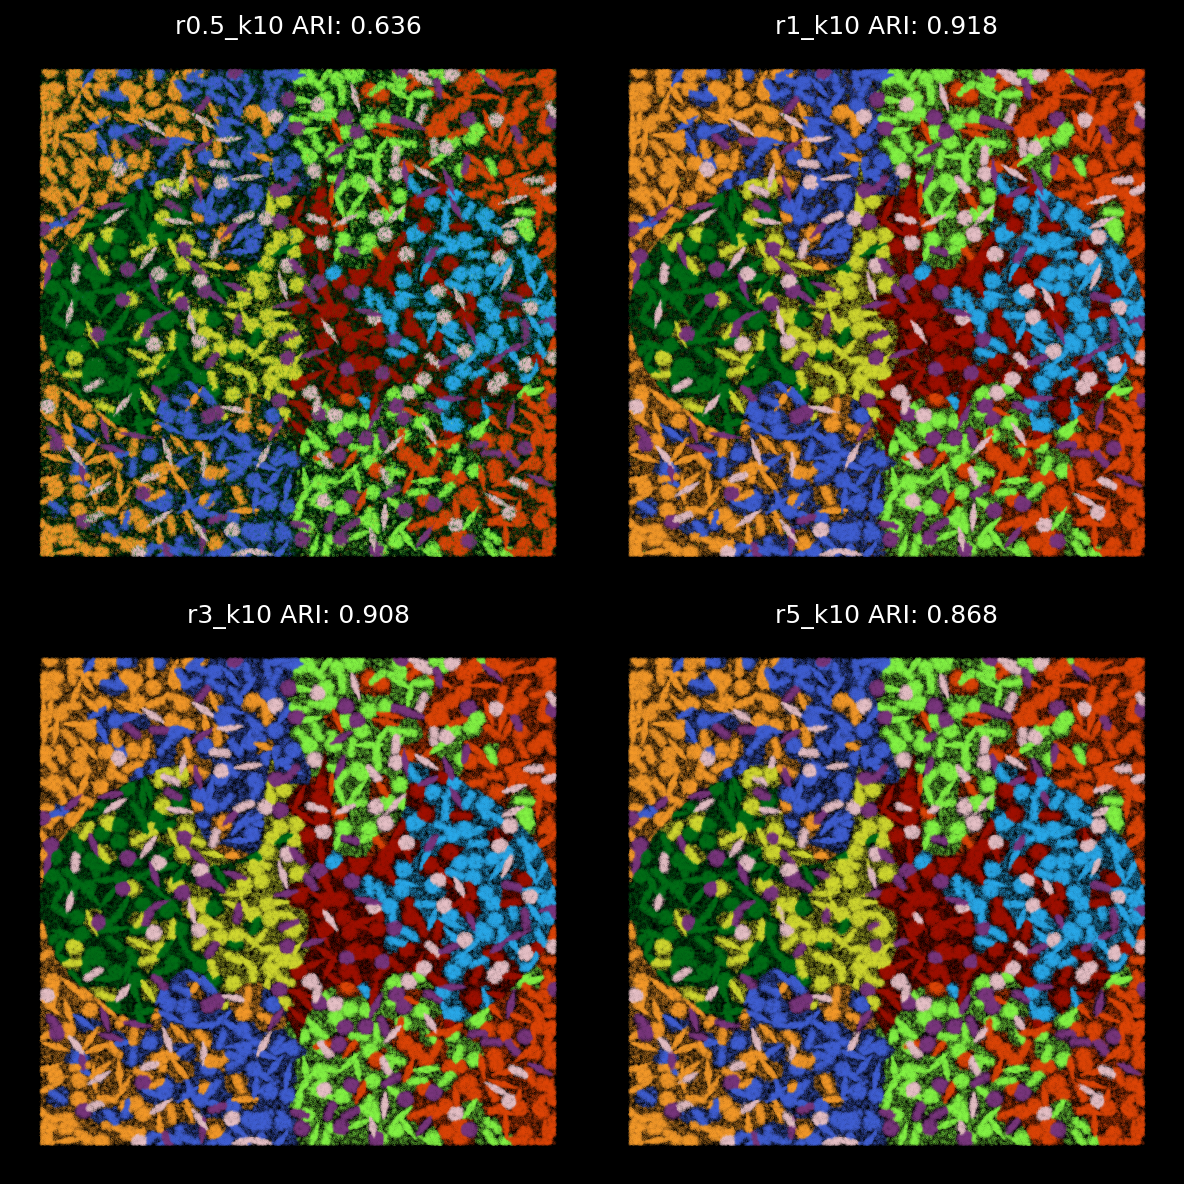

In [26]:
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['figure.dpi'] = 150

n_panels = len(kmeans_labels_df_labels.columns)
ncols = int(np.ceil(n_panels / 3))
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(8,8), sharey=True)
axes = axes.flatten()

for i, col_n in enumerate(kmeans_labels_df_labels.columns):
    axes[i].scatter(
        x=ground_truth_label.X, y=ground_truth_label.Y, s=0.01,
        c=[c_array[color_m[str(x)]] for x in kmeans_labels_df_labels[col_n]],
        alpha=1,marker='.'
    )
    axes[i].set_title(col_n + " ARI: " + "{:.3f}".format(ari_list[col_n]))
    axes[i].axis("off")

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("../figures/r_k10.png",dpi=300)
plt.show()

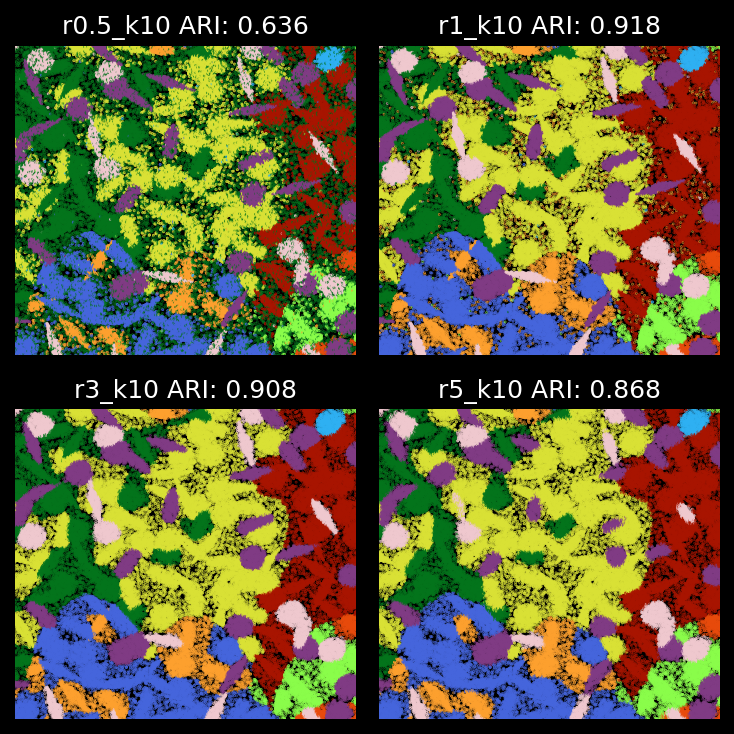

In [27]:
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['figure.dpi'] = 150

n_panels = len(kmeans_labels_df_labels.columns)
ncols = int(np.ceil(n_panels / 3))
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(5, 5), sharey=True)
axes = axes.flatten()

for i, col_n in enumerate(kmeans_labels_df_labels.columns):
    axes[i].scatter(
        x=ground_truth_label.X, y=ground_truth_label.Y, s=0.1,
        c=[c_array[color_m[str(x)]] for x in kmeans_labels_df_labels[col_n]],
        alpha=0.8,marker='o'
    )
    axes[i].set_title(col_n + " ARI: " + "{:.3f}".format(ari_list[col_n]))
    axes[i].axis("off")
    axes[i].set_xlim(100,300)
    axes[i].set_ylim(100,300)
    
# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("../figures/r_k10_100_300_square.png",dpi=300)
plt.show()

In [28]:
kmeans_labels_df_labels

r0.5_k10        r1_k10        r3_k10        r5_k10
0         fibroblast    fibroblast    fibroblast    fibroblast
1         fibroblast    fibroblast    fibroblast    fibroblast
2         fibroblast    fibroblast    fibroblast    fibroblast
3         fibroblast    fibroblast    fibroblast    fibroblast
4         fibroblast    fibroblast    fibroblast    fibroblast
...              ...           ...           ...           ...
557516  Kupffer_cell  Kupffer_cell  Kupffer_cell  Kupffer_cell
557517  keratinocyte  keratinocyte  keratinocyte  keratinocyte
557518    hepatocyte  keratinocyte  keratinocyte  keratinocyte
557519    hepatocyte  keratinocyte  keratinocyte  keratinocyte
557520  keratinocyte  keratinocyte  keratinocyte  keratinocyte

[557521 rows x 4 columns]

### Show 'bad-assignment' only

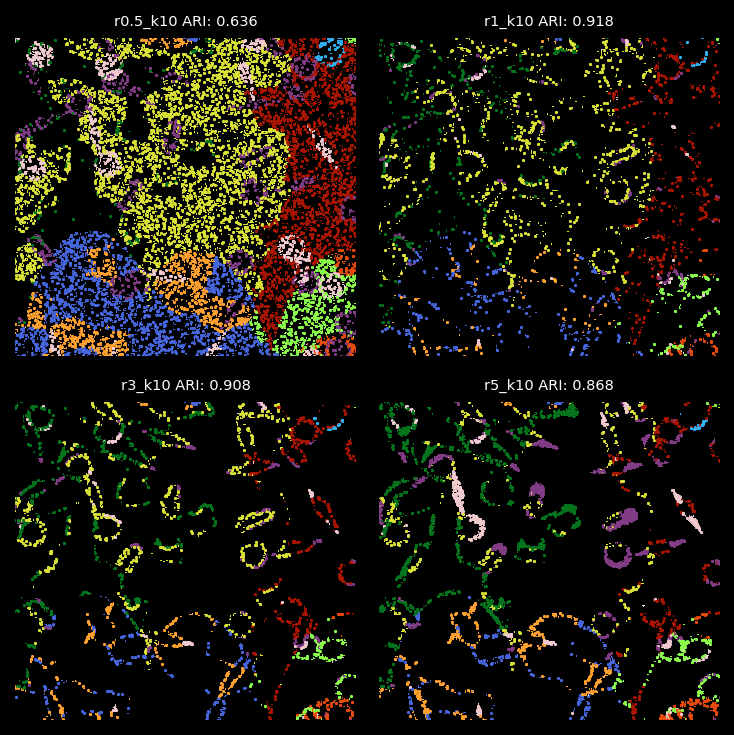

In [29]:
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['figure.dpi'] = '150'
plt.rcParams["scatter.marker"]= ','
plot_res = kmeans_labels_df_labels.columns
## plots color by the mapped cell label
fig,axes = plt.subplots(2,2,figsize=(5,5),sharey=True,sharex=True)
for col_n,ax in zip(plot_res,axes.flatten()):
    select_tx = ground_truth_label.cell_label != kmeans_labels_df_labels[col_n]

    ax.scatter(x = ground_truth_label[select_tx].X,y = ground_truth_label[select_tx].Y,
                    s=0.1,c=[c_array[color_m[str(x)]] for x in ground_truth_label[select_tx]["cell_label"]],alpha=1)
    
    acc_val = sum(ground_truth_label.cell_label == kmeans_labels_df_labels[col_n])/ground_truth_label.shape[0]
    
    ax.set_title( col_n +" ARI: "+"{:.3f}".format(ari_list[col_n]),size=7)
    ax.axis("off")
    ax.set_ylim(100,300)
    ax.set_xlim(100,300)
    
plt.tight_layout()
plt.savefig("../figures/zoom_in_bad_assignment.png",dpi=300)

In [34]:
kmeans_labels_df_labels

r0.5_k10        r1_k10        r3_k10        r5_k10
0         fibroblast    fibroblast    fibroblast    fibroblast
1         fibroblast    fibroblast    fibroblast    fibroblast
2         fibroblast    fibroblast    fibroblast    fibroblast
3         fibroblast    fibroblast    fibroblast    fibroblast
4         fibroblast    fibroblast    fibroblast    fibroblast
...              ...           ...           ...           ...
557516  Kupffer_cell  Kupffer_cell  Kupffer_cell  Kupffer_cell
557517  keratinocyte  keratinocyte  keratinocyte  keratinocyte
557518    hepatocyte  keratinocyte  keratinocyte  keratinocyte
557519    hepatocyte  keratinocyte  keratinocyte  keratinocyte
557520  keratinocyte  keratinocyte  keratinocyte  keratinocyte

[557521 rows x 4 columns]

In [62]:
plt.rcParams['figure.facecolor'] = 'black'
fig, ax = plt.subplots(figsize=(4, 6),dpi=300)
ax.axis("off")

# Create legend handles (colored circles)
handles = [
    plt.Line2D([0], [0], marker="o", color="black", markerfacecolor=row["hex"], markersize=10)
    for _, row in ground_truth_rgb.iterrows()
]
# Add legend
ax.legend(handles, ground_truth_rgb["cell_label"], loc="center", frameon=False, title="Cell Types")
plt.savefig('../figures/truth_legend.png',dpi=300)
plt.close()

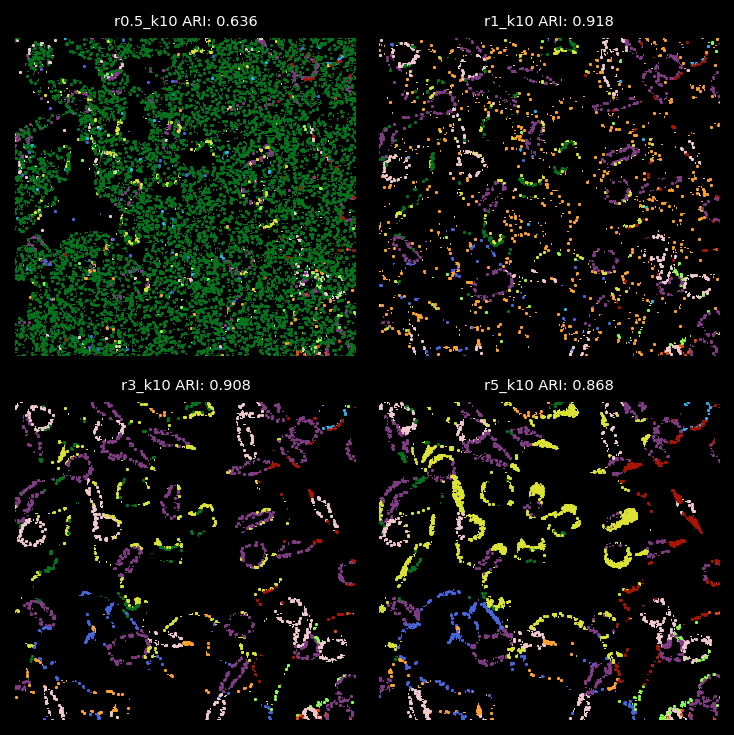

In [38]:
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['figure.dpi'] = '150'
plt.rcParams["scatter.marker"]= ','
plot_res = kmeans_labels_df_labels.columns
## plots color by the mapped cell label
fig,axes = plt.subplots(2,2,figsize=(5,5),sharey=True,sharex=True)
for col_n,ax in zip(plot_res,axes.flatten()):
    select_tx = ground_truth_label.cell_label != kmeans_labels_df_labels[col_n]

    ax.scatter(x = ground_truth_label[select_tx].X,y = ground_truth_label[select_tx].Y,
                    s=0.1,c=[c_array[color_m[str(x)]] for x in kmeans_labels_df_labels[col_n][select_tx]],alpha=1)
    
    #acc_val = sum(ground_truth_label.cell_label == kmeans_labels_df_labels[col_n])/ground_truth_label.shape[0]
    
    ax.set_title( col_n +" ARI: "+"{:.3f}".format(ari_list[col_n]),size=7)
    ax.axis("off")
    ax.set_ylim(100,300)
    ax.set_xlim(100,300)
    
plt.tight_layout()
plt.savefig("../figures/zoom_in_bad_assignment2.png",dpi=300)

## Summary

From the analysis above, the radius used for graph construction determines the size of spatial neighborhoods for information aggregation. A larger radius with fewer number of clusters leads to broader domain identification, while a smaller radius captures more localized structures. Since we applied 2-hop GNN model, the effective spatial aggregation for each focal node/transcript equals 2 times of the radius. In the simulation data, we find that radii of 1 or 3 are optimal for detecting the 10 simulated cell types with cell diameters or lengths roughly 12.